## Introduction and references

I was first made aware of this issue in http://haldanessieve.org/2014/03/21/author-post-genetic-influences-on-translation-in-yeast/, so we need to cite the post or the article.

For other informative references, see http://en.wikipedia.org/wiki/Total_least_squares and http://en.wikipedia.org/wiki/Errors-in-variables_models.  The problem we are trying to avoid here is attenuation bias or regression dilution (see http://en.wikipedia.org/wiki/Regression_dilution).

## Mass spec data and fitting

In [1]:
import numpy, pandas, scipy.stats, seaborn, pylab, scipy.odr
seaborn.set_style("white")

In [2]:
ms2_both_species = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y+H_MS2_BH.csv", index_col=1)
ms3_both_species = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y+H_MS3_BH.csv", index_col=1)
ms2_yeast = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y_only_MS2_BH.csv", index_col=1)
ms3_yeast = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y_only_MS3_BH.csv", index_col=1)

In [3]:
ms2_both_species.head()

,Unnamed: 0,126 Vert Med,127n Vert Med,127c Vert Med,128n Vert Med,128c Vert Med,129n Vert Med,batch_p_value,null_batch_p_value,1 vs 2,i_value,BH_value,Significant?,PepPerProt
ProteinID,,,,,,,,,,,,,,
YML009C,2819,312293.6903,307372.8028,305317.1813,853742.5699,835432.8687,842676.5201,4.170000e-08,0.512384,7.750000e-08,1,0.000172,True,1
YLR262C-A,2678,330290.1674,324090.2799,335944.6204,828722.5448,825534.7961,825114.2173,1.010000e-07,0.535342,1.670000e-08,2,0.000209,True,3
YCL026C-B,369,333521.3955,339539.8643,336577.0073,813773.4845,838498.8366,812688.3767,1.620000e-07,0.530168,5.930000e-07,3,0.000222,True,4
YJR060W,2163,853279.8707,836501.0098,842738.7702,395246.2931,406929.1902,400412.0544,2.130000e-07,0.490065,1.940000e-07,4,0.000219,True,5
Q0045,0,234746.4291,235839.0890,243317.0553,890467.3684,934305.2072,887251.1147,3.080000e-07,0.546969,1.720000e-06,5,0.000254,True,3


In [4]:
cols1 = ["126 Vert Med", "127n Vert Med", "127c Vert Med"]
cols2 = ["128n Vert Med", "128c Vert Med", "129n Vert Med"]

merged = pandas.DataFrame()

# not the best code here...
merged["MS2_both_species_ratios"] = ms2_both_species[cols2].mean(axis=1) / ms2_both_species[cols1].mean(axis=1)
merged["MS3_both_species_ratios"] = ms3_both_species[cols2].mean(axis=1) / ms3_both_species[cols1].mean(axis=1)

merged["MS2_yeast_ratios"] = ms2_yeast[cols2].mean(axis=1) / ms2_yeast[cols1].mean(axis=1)
merged["MS3_yeast_ratios"] = ms3_yeast[cols2].mean(axis=1) / ms3_yeast[cols1].mean(axis=1)

print merged.shape

(4117, 4)


## New results for Amanda (MS2 vs. MS3) (incorporated into manuscript)

In [5]:
# trying to factor out the previous code for shared reuse now...
def compare_columns(name1, name2, intercept=True, merged=merged):
    if not intercept:
        print "... constraining y intercept to be 0"
    temp = numpy.log2(merged[[name1, name2]].dropna())
    x = temp[name1]
    y = temp[name2]
    seaborn.jointplot(x, y, kind="reg")
    print "regressing y onto x (%s onto %s) (slope, intercept, ...):\n\t" % (name2, name1), scipy.stats.linregress(x, y)
    print "regressing x onto y (%s onto %s) (slope, intercept, ...):\n\t" % (name1, name2), scipy.stats.linregress(y, x)
    b_hat1 = scipy.odr.odr(lambda b, x : b[0]*x + intercept*b[1], [1.0, 0.0], y, x, full_output=False)[0]
    print ">>> ODR of y onto x (slope, intercept):", b_hat1
    pylab.plot(x, b_hat1[0]*x + b_hat1[1], "k--")
    b_hat2 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)[0]
    print "ODR of x onto y (slope, intercept):", b_hat2
    pylab.plot(b_hat2[0]*y + b_hat2[1], y, "m--", label="ODR regression line (slope=%.4f, n=%d)" % (b_hat1[0], len(x)))
    print "magenta and black dotted lines are from ODR fits"
    pylab.plot([min(min(x), min(y)), max(max(x), max(y))], [min(min(x), min(y)), max(max(x), max(y))], "k:", alpha=0.5, label="y=x")
    pylab.legend(loc="upper left")
    pylab.show()

... constraining y intercept to be 0
regressing y onto x (MS3_yeast_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=1.048669658160208, intercept=0.009485532199310844, rvalue=0.8170564717219819, pvalue=0.0, stderr=0.011796603911594837)
regressing x onto y (MS2_yeast_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.6365982583628692, intercept=0.008855948192646533, rvalue=0.8170564717219819, pvalue=0.0, stderr=0.007161166003308363)
>>> ODR of y onto x (slope, intercept): [1.35441347 0.        ]
ODR of x onto y (slope, intercept): [0.73790452 0.00313487]
magenta and black dotted lines are from ODR fits


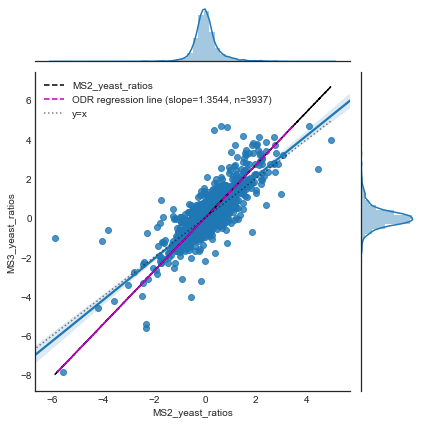

In [6]:
compare_columns("MS2_yeast_ratios", "MS3_yeast_ratios", intercept=False)

... constraining y intercept to be 0
regressing y onto x (MS3_both_species_ratios onto MS2_both_species_ratios) (slope, intercept, ...):
	LinregressResult(slope=1.175441094573658, intercept=-0.01120550226844614, rvalue=0.8278694436507094, pvalue=0.0, stderr=0.013670508536434938)
regressing x onto y (MS2_both_species_ratios onto MS3_both_species_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.5830728727236846, intercept=0.023592570545526482, rvalue=0.8278694436507094, pvalue=0.0, stderr=0.006781201304539964)
>>> ODR of y onto x (slope, intercept): [1.51676252 0.        ]
ODR of x onto y (slope, intercept): [0.6572303  0.01969743]
magenta and black dotted lines are from ODR fits


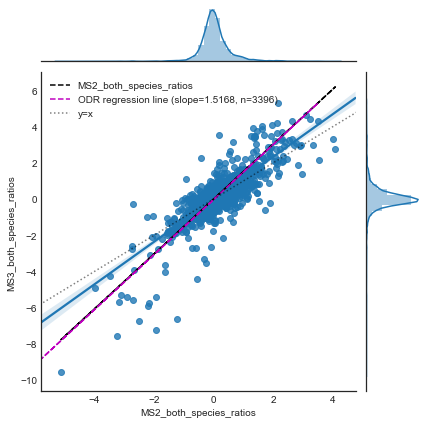

In [7]:
compare_columns("MS2_both_species_ratios", "MS3_both_species_ratios", intercept=False)

... constraining y intercept to be 0
regressing y onto x (MS2_both_species_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.7574965002958839, intercept=0.01795228636461886, rvalue=0.7933832413209791, pvalue=0.0, stderr=0.009196295196842065)
regressing x onto y (MS2_yeast_ratios onto MS2_both_species_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.8309701330146243, intercept=0.001558772199854376, rvalue=0.7933832413209791, pvalue=0.0, stderr=0.010088293001983028)
>>> ODR of y onto x (slope, intercept): [0.94516703 0.        ]
ODR of x onto y (slope, intercept): [ 1.06005622 -0.01027013]
magenta and black dotted lines are from ODR fits


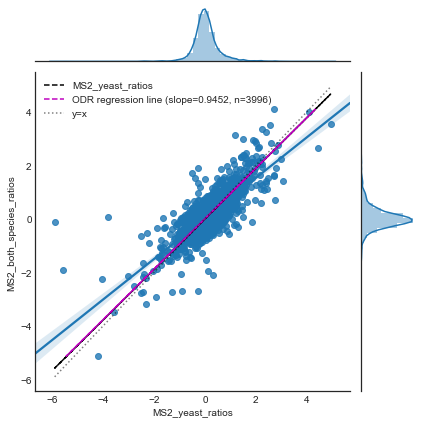

In [8]:
compare_columns("MS2_yeast_ratios", "MS2_both_species_ratios", intercept=False)

... constraining y intercept to be 0
regressing y onto x (MS3_both_species_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.9087319398321776, intercept=0.016752868623604103, rvalue=0.8412302491735489, pvalue=0.0, stderr=0.010076024284067628)
regressing x onto y (MS3_yeast_ratios onto MS3_both_species_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.7787426644817631, intercept=-4.5412538222149024e-05, rvalue=0.8412302491735489, pvalue=0.0, stderr=0.008634702550244762)
>>> ODR of y onto x (slope, intercept): [1.09696044 0.        ]
ODR of x onto y (slope, intercept): [ 0.91235755 -0.00768356]
magenta and black dotted lines are from ODR fits


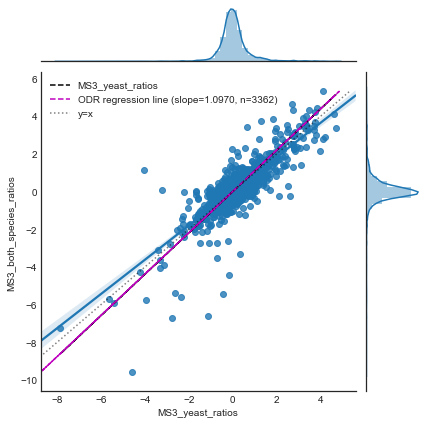

In [9]:
compare_columns("MS3_yeast_ratios", "MS3_both_species_ratios", intercept=False)

## Truncation analysis for ODR and MS2/MS3 comparisons (deprecated?)

I was trying to see if truncating outliers improved the fitting process, but all I discovered is that I had a bug where I reversed x and y in the arguments to the odr constructor.  Therefore, these results can be ignored and the results from the previous section used.

In [10]:
# trying to factor out the previous code for shared reuse now...
def compare_columns_truncated(name1, name2, truncate=True, merged=merged):
    temp = numpy.log2(merged[[name1, name2]].dropna())
    print "we're starting with", len(temp), "datapoints"
    if truncate:
        temp = temp[(numpy.abs(temp[name1]) <= 2) & (numpy.abs(temp[name2]) <= 2)]
    x = temp[name1]
    y = temp[name2]
    print "filtered based on max ratios to", len(temp), "datapoints"
    seaborn.jointplot(x, y, kind="reg")
    print "(plain) regressing y onto x (%s onto %s) (slope, intercept, ...):\n\t" % (name2, name1), scipy.stats.linregress(x, y)
    print "(plain) regressing x onto y (%s onto %s) (slope, intercept, ...):\n\t" % (name1, name2), scipy.stats.linregress(y, x)
    b_hat1 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], y, x, full_output=False)[0]
    print "ODR of y onto x (slope, intercept):", b_hat1
    pylab.plot(x, b_hat1[0]*x + b_hat1[1], "k:")
    b_hat2 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)[0]
    print "ODR of x onto y (slope, intercept):", b_hat2
    pylab.plot(b_hat2[0]*y + b_hat2[1], y, "m:")
    print "magenta and black dotted lines are from ODR fits"
    pylab.show()

regressing y onto x (MS3_yeast_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=1.048669658160208, intercept=0.009485532199310844, rvalue=0.8170564717219819, pvalue=0.0, stderr=0.011796603911594837)
regressing x onto y (MS2_yeast_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.6365982583628692, intercept=0.008855948192646533, rvalue=0.8170564717219819, pvalue=0.0, stderr=0.007161166003308363)
>>> ODR of y onto x (slope, intercept): [ 1.35514635 -0.00424738]
ODR of x onto y (slope, intercept): [0.73790452 0.00313487]
magenta and black dotted lines are from ODR fits


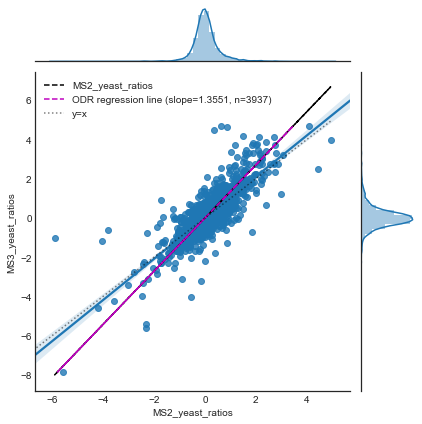

In [11]:
compare_columns("MS2_yeast_ratios", "MS3_yeast_ratios")

we're starting with 3937 datapoints
filtered based on max ratios to 3828 datapoints
(plain) regressing y onto x (MS3_yeast_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.9550780870590339, intercept=-0.0008268285209002378, rvalue=0.7822700867261876, pvalue=0.0, stderr=0.012295762992576693)
(plain) regressing x onto y (MS2_yeast_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.6407292732167693, intercept=0.010528404184417894, rvalue=0.7822700867261876, pvalue=0.0, stderr=0.008248807498179312)
ODR of y onto x (slope, intercept): [ 1.28928541 -0.00943803]
ODR of x onto y (slope, intercept): [0.77561153 0.00732066]
magenta and black dotted lines are from ODR fits


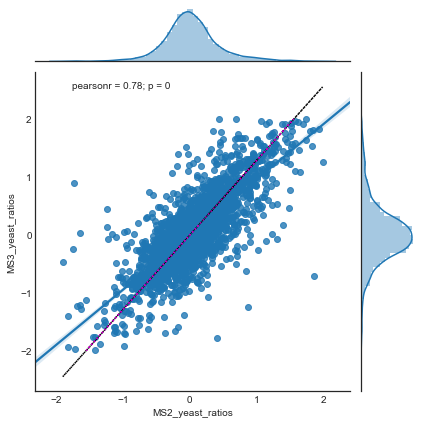

In [12]:
compare_columns_truncated("MS2_yeast_ratios", "MS3_yeast_ratios")

we're starting with 8 datapoints
filtered based on max ratios to 8 datapoints
(plain) regressing y onto x (y onto x) (slope, intercept, ...):
	LinregressResult(slope=1.9844820935821732, intercept=0.10752455271044248, rvalue=0.9984107500639525, pvalue=1.0023025163247928e-08, stderr=0.04572995676479146)
(plain) regressing x onto y (x onto y) (slope, intercept, ...):
	LinregressResult(slope=0.502309408115598, intercept=-0.03967901104760685, rvalue=0.9984107500639525, pvalue=1.0023025163247928e-08, stderr=0.011575104451665904)
ODR of y onto x (slope, intercept): [1.98952705 0.08475916]
ODR of x onto y (slope, intercept): [ 0.50263207 -0.04260311]
magenta and black dotted lines are from ODR fits


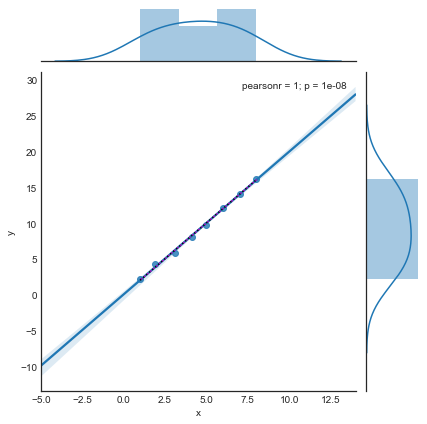

In [13]:
# so let's run a test case where the equation is definitely y = 2 * x (more or less)
test_df = pandas.DataFrame({"x":[1.0,1.9,3.1,4.1,5,6,7,8], 
                            "y":[2.2, 4.3, 5.8, 8.1, 9.8, 12.1, 14.0, 16.2]})
test_df = numpy.power(2, test_df) # because the method log2's everything

compare_columns_truncated("x", "y", False, test_df)
# regression lines should all match up, with all y-on-x regressions having slope of ~2

## Extending to heteroscedastic errors using ODR framework (not used)

In [14]:
# print numpy.average(numpy.log2(df[cols]), axis=0).shape

MS2_yeast nan nan


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


MS3_yeast nan nan
MS2_both_species 0.03148704137454089 0.023862431397434627
MS3_both_species nan nan


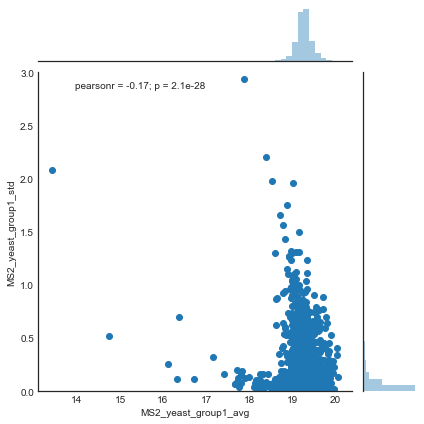

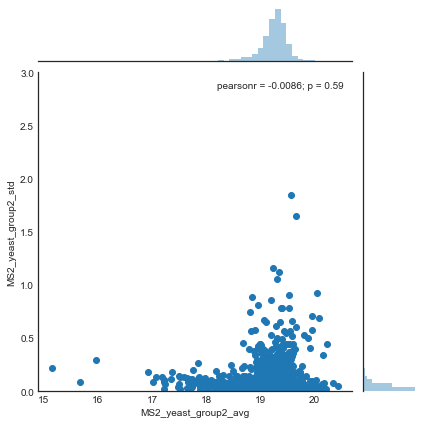

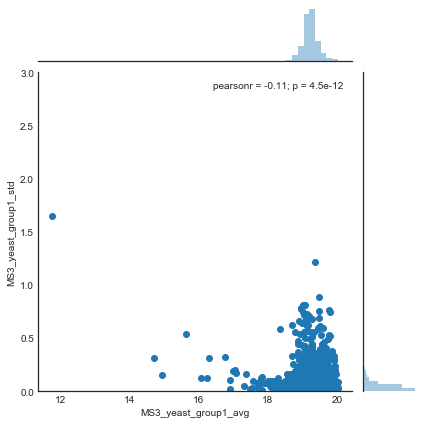

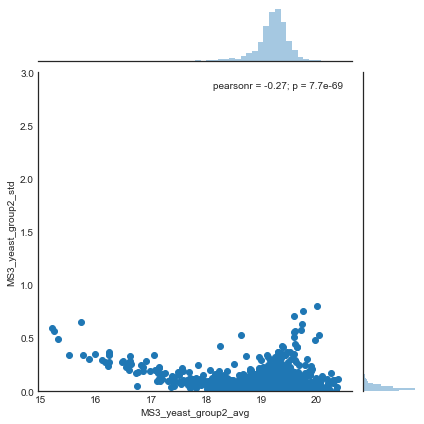

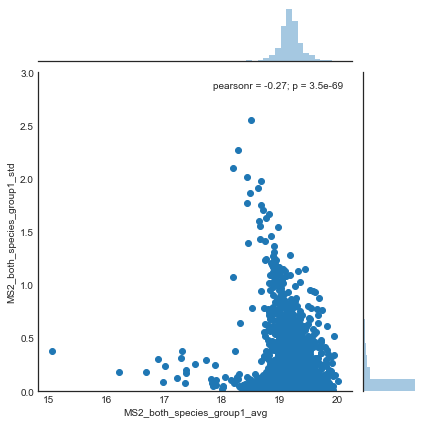

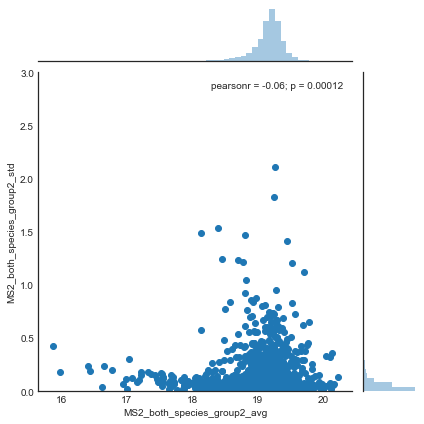

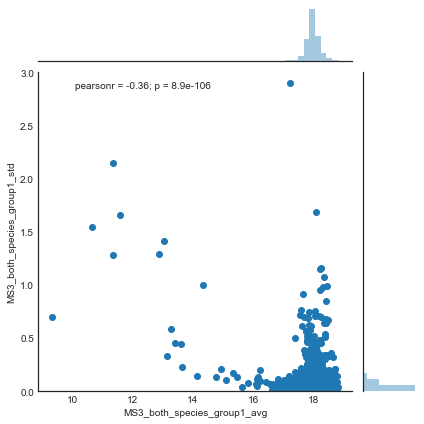

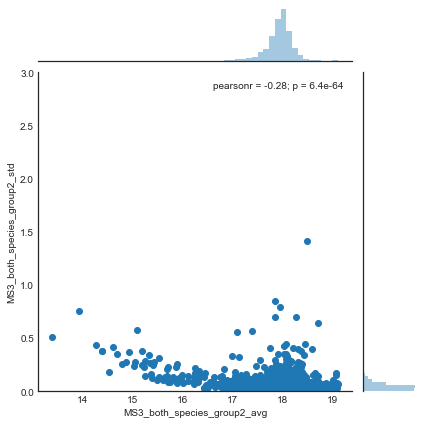

In [15]:
cols1 = ["126 Vert Med", "127n Vert Med", "127c Vert Med"]
cols2 = ["128n Vert Med", "128c Vert Med", "129n Vert Med"]

# merged = pandas.DataFrame()

for group, df in [("MS2_both_species", ms2_both_species), 
                  ("MS3_both_species", ms3_both_species), 
                  ("MS2_yeast", ms2_yeast), 
                  ("MS3_yeast", ms3_yeast)
                 ]:
    for setname, cols in [("group1", cols2), ("group2", cols1)]: 
        merged["%s_%s_avg" % (group, setname)] = pandas.Series(numpy.average(numpy.log2(df[cols]), axis=1), index=df.index)
        merged["%s_%s_std" % (group, setname)] = pandas.Series(numpy.std(numpy.log2(df[cols]), axis=1), index=df.index)

medianmedian = lambda v: numpy.median(numpy.abs(v - numpy.median(v)))

# print merged.head()
for group in ["MS2_yeast", "MS3_yeast", "MS2_both_species", "MS3_both_species"]:
    seaborn.jointplot("%s_group1_avg" % group, "%s_group1_std" % group, data=merged)
    pylab.ylim(0, 3)
    seaborn.jointplot("%s_group2_avg" % group, "%s_group2_std" % group, data=merged)
    print group, medianmedian(merged["%s_group1_std" % group]), medianmedian(merged["%s_group2_std" % group])
    pylab.ylim(0, 3)
pylab.show()

LinregressResult(slope=0.7317576154189939, intercept=0.0008057781809469142, rvalue=0.7752571574737199, pvalue=0.0, stderr=0.009433894321452462)
Beta: [ 1.09340657 -0.00238408]
Beta Std Error: [0.00976289 0.00059072]
Beta Covariance: [[1.94271127 0.01000308]
 [0.01000308 0.00711235]]
Residual Variance: 4.90623356893e-05
Inverse Condition #: 0.678902672561
Reason(s) for Halting:
  Sum of squares convergence
Beta: [9.28237335e-01 3.22583180e-04]
Beta Std Error: [0.01045845 0.00042848]
Beta Covariance: [[ 0.2785521  -0.00068502]
 [-0.00068502  0.00046756]]
Residual Variance: 0.000392670602641
Inverse Condition #: 0.481713581302
Reason(s) for Halting:
  Sum of squares convergence


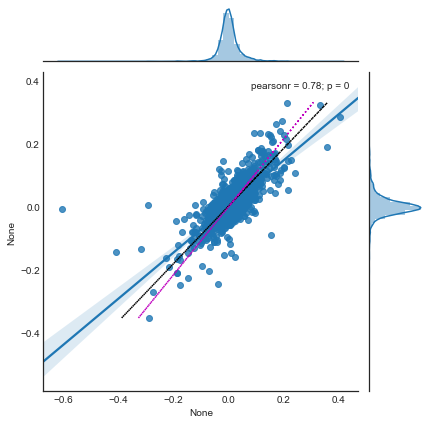

In [16]:
# total least squares regression with empirical standard deviations used in fitting, MS2
temp = numpy.log2(merged[["MS2_yeast_group1_avg", "MS2_yeast_group2_avg", 
                          "MS2_yeast_group1_std", "MS2_yeast_group2_std",
                          "MS2_both_species_group1_avg", "MS2_both_species_group2_avg", 
                          "MS2_both_species_group1_std", "MS2_both_species_group2_std",
                         ]].dropna())
x = temp[temp.columns[0]] - temp[temp.columns[1]]
y = temp[temp.columns[4]] - temp[temp.columns[5]]
sx = 0.5 * temp[temp.columns[2]] + 0.5 * temp[temp.columns[3]]
sy = 0.5 * temp[temp.columns[6]] + 0.5 * temp[temp.columns[7]]
print scipy.stats.linregress(x, y)

# pylab.plot(x, y, 'o', alpha=0.5)
seaborn.jointplot(x, y, kind="reg")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y, sx=sx, sy=sy)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "k:")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "m:")

pylab.show()

LinregressResult(slope=0.989856344990557, intercept=0.0010084286302570887, rvalue=0.8279944088391619, pvalue=0.0, stderr=0.011564685908413938)
Beta: [ 1.22996549 -0.0019074 ]
Beta Std Error: [0.01067278 0.00096061]
Beta Covariance: [[ 1.91778942 -0.0122773 ]
 [-0.0122773   0.01553596]]
Residual Variance: 5.9395567796e-05
Inverse Condition #: 0.908733856811
Reason(s) for Halting:
  Sum of squares convergence
Beta: [1.24000404e+00 1.71005034e-04]
Beta Std Error: [0.01317503 0.00070797]
Beta Covariance: [[ 0.26241709 -0.00087853]
 [-0.00087853  0.00075774]]
Residual Variance: 0.000661471337397
Inverse Condition #: 0.621003449131
Reason(s) for Halting:
  Sum of squares convergence


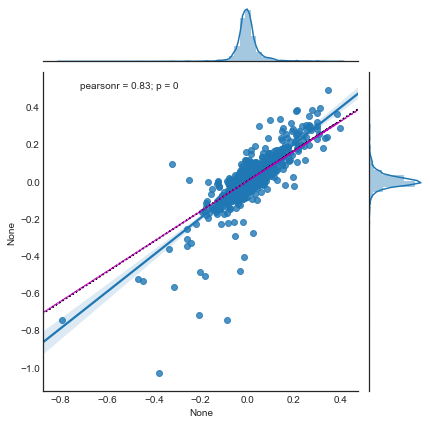

In [17]:
# total least squares regression with empirical standard deviations used in fitting, MS3
temp = numpy.log2(merged[["MS3_yeast_group1_avg", "MS3_yeast_group2_avg", 
                          "MS3_yeast_group1_std", "MS3_yeast_group2_std",
                          "MS3_both_species_group1_avg", "MS3_both_species_group2_avg", 
                          "MS3_both_species_group1_std", "MS3_both_species_group2_std",
                         ]].dropna())
x = temp[temp.columns[0]] - temp[temp.columns[1]]
y = temp[temp.columns[4]] - temp[temp.columns[5]]
sx = 0.5 * temp[temp.columns[2]] + 0.5 * temp[temp.columns[3]]
sy = 0.5 * temp[temp.columns[6]] + 0.5 * temp[temp.columns[7]]
print scipy.stats.linregress(x, y)

# pylab.plot(x, y, 'o', alpha=0.5)
seaborn.jointplot(x, y, kind="reg")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y, sx=sx, sy=sy)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "k:")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "m:")
    
pylab.show()

(3996, 8)
(3596, 8)
LinregressResult(slope=0.7289538071777707, intercept=0.000790380612813661, rvalue=0.7714014190002991, pvalue=0.0, stderr=0.010030574270492115)
Beta: [9.29270594e-01 2.94941071e-04]
Beta Std Error: [0.01114367 0.00041495]
Beta Covariance: [[ 0.37541784 -0.00092852]
 [-0.00092852  0.00052052]]
Residual Variance: 0.000330781620123
Inverse Condition #: 0.436628908267
Reason(s) for Halting:
  Sum of squares convergence
total least squares slope and intercept: [9.29270594e-01 2.94941071e-04]


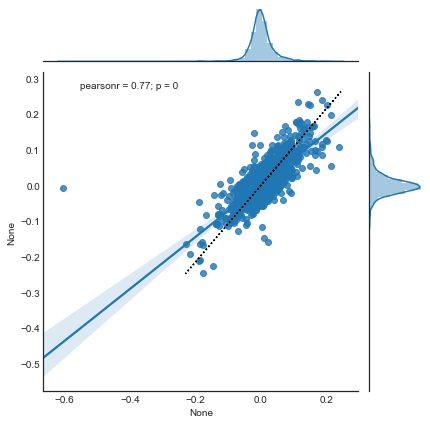

In [18]:
# total least squares regression after filtering genes with extreme variance, MS2
temp = numpy.log2(merged[["MS2_yeast_group1_avg", "MS2_yeast_group2_avg", 
                          "MS2_yeast_group1_std", "MS2_yeast_group2_std",
                          "MS2_both_species_group1_avg", "MS2_both_species_group2_avg", 
                          "MS2_both_species_group1_std", "MS2_both_species_group2_std",
                         ]].dropna())
sx = 0.5 * temp[temp.columns[2]] + 0.5 * temp[temp.columns[3]]
sy = 0.5 * temp[temp.columns[6]] + 0.5 * temp[temp.columns[7]]
noise = 0.5 * sx + 0.5 * sy
print temp.shape
temp = temp[noise < numpy.percentile(noise, 90)]
print temp.shape

x = temp[temp.columns[0]] - temp[temp.columns[1]]
y = temp[temp.columns[4]] - temp[temp.columns[5]]
print scipy.stats.linregress(x, y)

# pylab.plot(x, y, 'o', alpha=0.5)
seaborn.jointplot(x, y, kind="reg")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    print "total least squares slope and intercept:", fit.beta
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "k:")

pylab.show()

(3362, 8)
(3025, 8)
LinregressResult(slope=0.895523438358482, intercept=0.0014477279343547238, rvalue=0.7757748575785219, pvalue=0.0, stderr=0.013248243105264379)
Beta: [1.20274529 0.0012621 ]
Beta Std Error: [0.01560496 0.00064096]
Beta Covariance: [[ 4.79507158e-01 -2.89734057e-04]
 [-2.89734057e-04  8.08968065e-04]]
Residual Variance: 0.000507844012197
Inverse Condition #: 0.492762047262
Reason(s) for Halting:
  Sum of squares convergence
total least squares slope and intercept: [1.20274529 0.0012621 ]


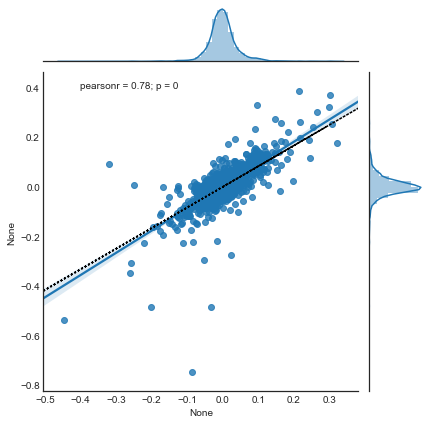

In [19]:
# total least squares regression after filtering genes with extreme variance, MS3
temp = numpy.log2(merged[["MS3_yeast_group1_avg", "MS3_yeast_group2_avg", 
                          "MS3_yeast_group1_std", "MS3_yeast_group2_std",
                          "MS3_both_species_group1_avg", "MS3_both_species_group2_avg", 
                          "MS3_both_species_group1_std", "MS3_both_species_group2_std",
                         ]].dropna())
sx = 0.5 * temp[temp.columns[2]] + 0.5 * temp[temp.columns[3]]
sy = 0.5 * temp[temp.columns[6]] + 0.5 * temp[temp.columns[7]]
noise = 0.5 * sx + 0.5 * sy
print temp.shape
temp = temp[noise < numpy.percentile(noise, 90)]
print temp.shape

x = temp[temp.columns[0]] - temp[temp.columns[1]]
y = temp[temp.columns[4]] - temp[temp.columns[5]]
print scipy.stats.linregress(x, y)

# pylab.plot(x, y, 'o', alpha=0.5)
seaborn.jointplot(x, y, kind="reg")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "k:")
    print "total least squares slope and intercept:", fit.beta


pylab.show()

## Simulated results for testing

In [20]:
N = 1000
# true = scipy.stats.uniform.rvs(-5, 10, size=N)
true = scipy.stats.norm.rvs(0, 2, size=N)
x = true + scipy.stats.norm.rvs(0, 0.75, size=N)
y = true + scipy.stats.norm.rvs(0, 0.75, size=N)

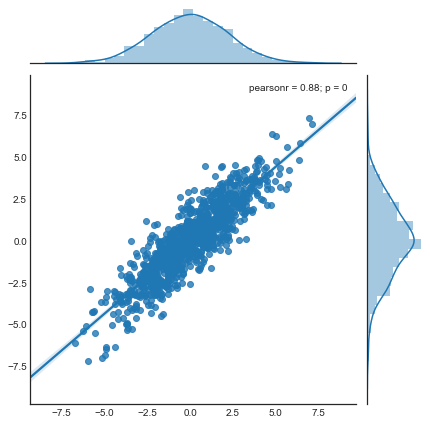

In [21]:
seaborn.jointplot(x, y, kind="reg")
pylab.show()

In [22]:
print scipy.stats.linregress(x, y)
print scipy.stats.linregress(y, x)

LinregressResult(slope=0.8800811984674539, intercept=0.019421515392911252, rvalue=0.8816311296675998, pvalue=0.0, stderr=0.014912709306319313)
LinregressResult(slope=0.8831837904871596, intercept=-0.01974828861847884, rvalue=0.8816311296675998, pvalue=0.0, stderr=0.014965281788229557)


In [23]:
import scipy.odr
# quick version using the low-level function
print scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], y, x, full_output=False)
print scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)

(array([0.99800294, 0.02079604]), array([0.01584704, 0.0337137 ]), array([[4.41018955e-04, 5.13950013e-06],
       [5.13950013e-06, 1.99606128e-03]]))
(array([ 1.00199453, -0.02083724]), array([0.01591042, 0.03378092]), array([[ 4.44553777e-04, -4.07463179e-06],
       [-4.07463179e-06,  2.00402860e-03]]))


In [24]:
# expanded version
model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
data = scipy.odr.RealData(x, y)
odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
fit = odr.run()
fit.pprint()
print "\n"
data = scipy.odr.RealData(y, x)
odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
fit = odr.run()
fit.pprint()

Beta: [0.99800294 0.02079604]
Beta Std Error: [0.01584704 0.0337137 ]
Beta Covariance: [[4.41018955e-04 5.13950013e-06]
 [5.13950013e-06 1.99606128e-03]]
Residual Variance: 0.569428311939
Inverse Condition #: 0.0490917751475
Reason(s) for Halting:
  Sum of squares convergence


Beta: [ 1.00199453 -0.02083724]
Beta Std Error: [0.01591042 0.03378092]
Beta Covariance: [[ 4.44553777e-04 -4.07463179e-06]
 [-4.07463179e-06  2.00402860e-03]]
Residual Variance: 0.569428311941
Inverse Condition #: 0.0491970950649
Reason(s) for Halting:
  Sum of squares convergence


Notice that the simple least squares estimates are downwardly-biased ($0.88$ here).  The total least squares estimates are much more accurate ($1.00$).


## Updated peptide-level plots for reviewer response (2/19/2016)

In [25]:
# load peptide-level data
ms2_both_species_pep = pandas.read_csv("Interference_peptide_ratio_files/False_neg_Y+H_MS2_peptides.csv", index_col=0)
ms3_both_species_pep = pandas.read_csv("Interference_peptide_ratio_files/False_neg_Y+H_MS3_peptides.csv", index_col=0)
ms2_yeast_pep = pandas.read_csv("Interference_peptide_ratio_files/False_neg_Y_only_MS2_peptides.csv", index_col=0)
ms3_yeast_pep = pandas.read_csv("Interference_peptide_ratio_files/False_neg_Y_only_MS3_peptides.csv", index_col=0)

ms2_both_species_pep.head(3)

,126 Vert Med,127n Vert Med,127c Vert Med,128n Vert Med,128c Vert Med,129n Vert Med
Peptide + Charge State,,,,,,
-.M*ADFLLRPIK.Q_2,89897.17856,98125.59881,96773.34251,79785.12770,89182.26410,105354.37460
-.M*FGLPQQEVSEEEK.R_3,89251.15240,89802.90389,98597.84947,92271.74104,93133.00108,95706.53594
-.M*FNNHEIDTILSTLR.M_2,98336.74312,100633.05220,98037.41826,83448.46690,89089.12381,91199.44736


In [26]:
cols1 = ["126 Vert Med", "127n Vert Med", "127c Vert Med"]
cols2 = ["128n Vert Med", "128c Vert Med", "129n Vert Med"]

merged_peptides = pandas.DataFrame()

# not the best code here...
merged_peptides["MS2_both_species_ratios"] = ms2_both_species_pep[cols2].mean(axis=1) / ms2_both_species_pep[cols1].mean(axis=1)
merged_peptides["MS3_both_species_ratios"] = ms3_both_species_pep[cols2].mean(axis=1) / ms3_both_species_pep[cols1].mean(axis=1)

merged_peptides["MS2_yeast_ratios"] = ms2_yeast_pep[cols2].mean(axis=1) / ms2_yeast_pep[cols1].mean(axis=1)
merged_peptides["MS3_yeast_ratios"] = ms3_yeast_pep[cols2].mean(axis=1) / ms3_yeast_pep[cols1].mean(axis=1)

print merged_peptides.shape

(30990, 4)


... constraining y intercept to be 0
regressing y onto x (MS3_yeast_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=1.2144199487271603, intercept=-0.006848359023001011, rvalue=0.8614475039641335, pvalue=0.0, stderr=0.00676372744928586)
regressing x onto y (MS2_yeast_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.6110668742421647, intercept=0.003376837116884971, rvalue=0.8614475039641335, pvalue=0.0, stderr=0.003403344777885897)
>>> ODR of y onto x (slope, intercept): [1.48605757 0.        ]
ODR of x onto y (slope, intercept): [0.67295042 0.00403571]
magenta and black dotted lines are from ODR fits


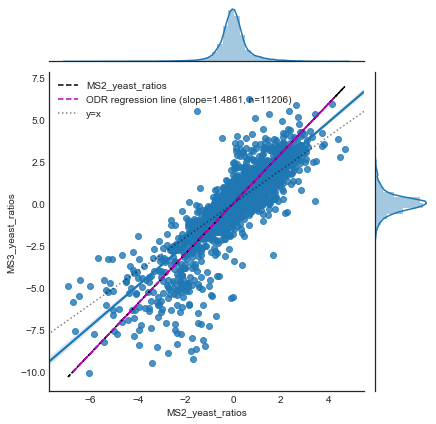

In [27]:
compare_columns("MS2_yeast_ratios", "MS3_yeast_ratios", intercept=False, merged=merged_peptides)

... constraining y intercept to be 0
regressing y onto x (MS3_both_species_ratios onto MS2_both_species_ratios) (slope, intercept, ...):
	LinregressResult(slope=1.1904148930851535, intercept=-0.038159554158942684, rvalue=0.871235548471954, pvalue=0.0, stderr=0.005728878627411992)
regressing x onto y (MS2_both_species_ratios onto MS3_both_species_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.6376359917289186, intercept=0.02843842899426044, rvalue=0.871235548471954, pvalue=0.0, stderr=0.0030686269352841063)
>>> ODR of y onto x (slope, intercept): [1.42859591 0.        ]
ODR of x onto y (slope, intercept): [0.70010578 0.02955486]
magenta and black dotted lines are from ODR fits


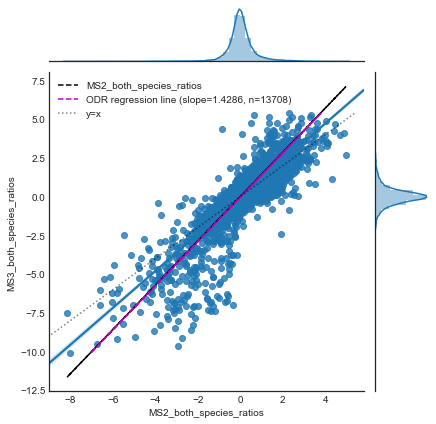

In [28]:
compare_columns("MS2_both_species_ratios", "MS3_both_species_ratios", intercept=False, merged=merged_peptides)

... constraining y intercept to be 0
regressing y onto x (MS2_both_species_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.8248266712967117, intercept=0.02890813266737647, rvalue=0.85580435713302, pvalue=0.0, stderr=0.004072747653269853)
regressing x onto y (MS2_yeast_ratios onto MS2_both_species_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.8879454595429758, intercept=-0.024045969927682632, rvalue=0.85580435713302, pvalue=0.0, stderr=0.00438440937039531)
>>> ODR of y onto x (slope, intercept): [0.95897434 0.        ]
ODR of x onto y (slope, intercept): [ 1.04401213 -0.0293382 ]
magenta and black dotted lines are from ODR fits


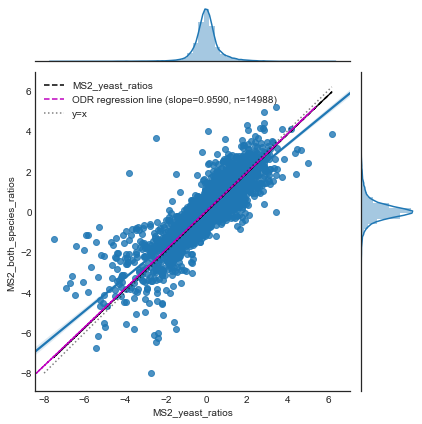

In [29]:
compare_columns("MS2_yeast_ratios", "MS2_both_species_ratios", intercept=False, merged=merged_peptides)

... constraining y intercept to be 0
regressing y onto x (MS3_both_species_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.8963098997642975, intercept=0.0021854582303086935, rvalue=0.9016841944715882, pvalue=0.0, stderr=0.004292817393166512)
regressing x onto y (MS3_yeast_ratios onto MS3_both_species_ratios) (slope, intercept, ...):
	LinregressResult(slope=0.9070907135731517, intercept=-0.008458719182114691, rvalue=0.9016841944715882, pvalue=0.0, stderr=0.004344451392794665)
>>> ODR of y onto x (slope, intercept): [0.99321783 0.        ]
ODR of x onto y (slope, intercept): [ 1.00665067 -0.00558552]
magenta and black dotted lines are from ODR fits


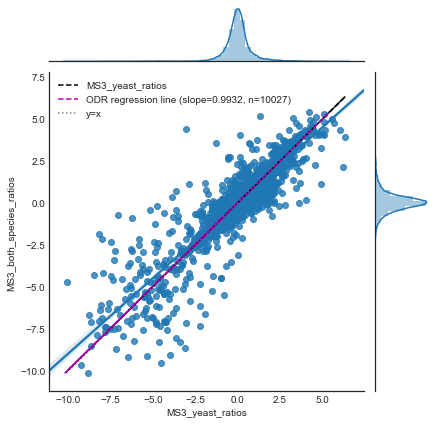

In [30]:
compare_columns("MS3_yeast_ratios", "MS3_both_species_ratios", intercept=False, merged=merged_peptides)

## Updated data (3/13/2018)

In [31]:
# load peptide-level data
ms2_both_species = pandas.read_csv("Updated_data_for_interference_ratios_plots/MS2 Y vs Y+H.csv")
ms3_both_species = pandas.read_csv("Updated_data_for_interference_ratios_plots/MS3 Y vs Y+H.csv")
ms2_vs_ms3_yeast = pandas.read_csv("Updated_data_for_interference_ratios_plots/Yeast only MS3 vs MS2.csv")

ms2_vs_ms3_yeast.head(3)

,MS3,MS2
0,-7.659247,-5.963628
1,-6.621488,-4.982466
2,-1.312338,-4.517097


... constraining y intercept to be 0
regressing y onto x (Yeast + Human onto Yeast) (slope, intercept, ...):
	LinregressResult(slope=0.6592107947827568, intercept=0.012969697666884258, rvalue=0.7663013885294097, pvalue=0.0, stderr=0.010109326231945428)
regressing x onto y (Yeast onto Yeast + Human) (slope, intercept, ...):
	LinregressResult(slope=0.8907891416669218, intercept=-0.008686303027608006, rvalue=0.7663013885294097, pvalue=0.0, stderr=0.013660695650400049)
>>> ODR of y onto x (slope, intercept): [0.82252625 0.        ]
ODR of x onto y (slope, intercept): [ 1.21641459 -0.01440051]
magenta and black dotted lines are from ODR fits


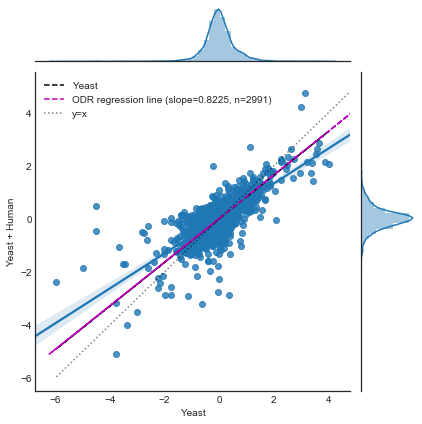

... constraining y intercept to be 0
regressing y onto x (Yeast + Human onto Yeast) (slope, intercept, ...):
	LinregressResult(slope=0.8289068707597207, intercept=0.013874504501972171, rvalue=0.7788808899707658, pvalue=0.0, stderr=0.01219615264713642)
regressing x onto y (Yeast onto Yeast + Human) (slope, intercept, ...):
	LinregressResult(slope=0.7318740647011795, intercept=-0.002195908918045098, rvalue=0.7788808899707658, pvalue=0.0, stderr=0.010768456778980202)
>>> ODR of y onto x (slope, intercept): [1.08361155 0.        ]
ODR of x onto y (slope, intercept): [ 0.92321127 -0.00805893]
magenta and black dotted lines are from ODR fits


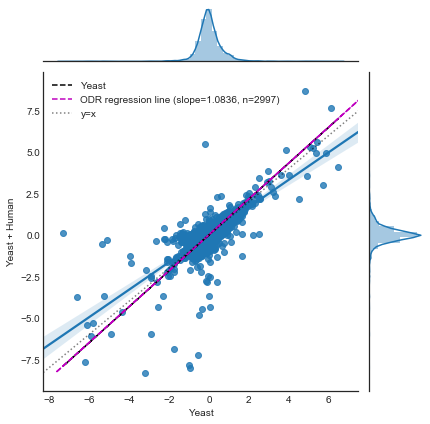

... constraining y intercept to be 0
regressing y onto x (MS2 onto MS3) (slope, intercept, ...):
	LinregressResult(slope=0.6452079024884756, intercept=-0.004269794953663626, rvalue=0.8204952351008842, pvalue=0.0, stderr=0.007300951885687057)
regressing x onto y (MS3 onto MS2) (slope, intercept, ...):
	LinregressResult(slope=1.0434038830379637, intercept=0.012434857606451208, rvalue=0.8204952351008842, pvalue=0.0, stderr=0.011806801370563322)
>>> ODR of y onto x (slope, intercept): [0.74683504 0.        ]
ODR of x onto y (slope, intercept): [1.33853424 0.00904496]
magenta and black dotted lines are from ODR fits


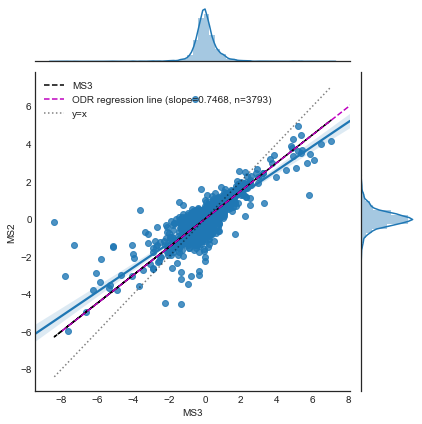

In [32]:
for df in [ms2_both_species,
           ms3_both_species,
           ms2_vs_ms3_yeast]:
    compare_columns(df.columns[0],
                    df.columns[1],
                    intercept=False,
                    merged=numpy.power(2.0, df))